/tmp/ipykernel_594383/646124581.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


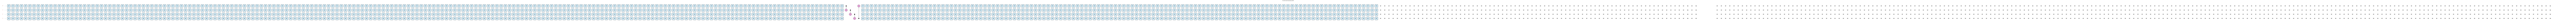

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x732f19590490>>
Traceback (most recent call last):
  File "/home/yangz2/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 794, in _clean_thread_parent_frames
    for identity in list(thread_to_parent_header.keys()):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [2]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 数据加载与预处理
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)
mask = (y == "0") | (y == "1")
X, y = X[mask] / 255 * np.pi, y[mask].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 回路超参
n_qubits   = 4
chunk_size = n_qubits
n_chunks   = X.shape[1] // chunk_size  # 784//4 = 196
n_layers   = 3

# 经典模拟器设备
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def reupload_qnn(x, weights):
    for l in range(n_layers):
        # —— 分块 RY(x) 编码 —— 
        for i in range(n_chunks):
            base = i * chunk_size
            for q in range(chunk_size):
                qml.RY(x[base + q], wires=q)
        # —— 可训练旋转层 —— 
        for q in range(n_qubits):
            qml.RX(weights[l, q, 0], wires=q)
            qml.RY(weights[l, q, 1], wires=q)
            qml.RZ(weights[l, q, 2], wires=q)
        # —— 环形纠缠 —— 
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q + 1) % n_qubits])
    return qml.expval(qml.PauliZ(0))

# 初始化参数 & 优化器
np.random.seed(0)
weights = np.random.normal(0, np.pi, (n_layers, n_qubits, 3), requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# 彩色电路图
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(
    reupload_qnn,
    wire_order=range(n_qubits),
    show_all_wires=True,
    style="pennylane",
    wire_options={"color": "teal", "linewidth": 2},
    label_options={"size": 10, "color": "darkred"},
)(X_train[0], weights)
ax.set_title("Chunked Data‑Reuploading QNN", pad=16)
plt.tight_layout()
plt.show()

def loss_fn(w):
    preds = np.array([reupload_qnn(x, w) for x in X_train])
    return np.mean((preds - (1 - 2 * y_train))**2)

# 训练
for epoch in range(1, 11):
    weights, loss = opt.step_and_cost(loss_fn, weights)
    tr_acc = np.mean((np.array([reupload_qnn(x, weights) for x in X_train])>0) == (y_train==0))
    te_acc = np.mean((np.array([reupload_qnn(x, weights) for x in X_test ])>0) == (y_test ==0))
    print(f"[Reupload] Epoch {epoch:2d}  loss={loss:.4f}  train_acc={tr_acc:.3f}  test_acc={te_acc:.3f}")
